In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

# Create a target directory for data
data_dir = '/content/data'
os.makedirs(data_dir, exist_ok=True)

# Unzip the combined zip file
with zipfile.ZipFile('/content/drive/MyDrive/Industrial-Equipment.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)


In [ ]:
data_dir = '/content/data/Industrial-Equipment'

In [ ]:
data_dir

'/content/data/Industrial-Equipment'

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Set up data directories and parameters
data_dir = '/content/data/Industrial-Equipment'
img_size = (224, 224)
batch_size = 32
epochs = 5


In [ ]:
# Data Preprocessing and Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,       # 15% for validation
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    directory=data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    directory=data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 5857 images belonging to 2 classes.
Found 1033 images belonging to 2 classes.


In [ ]:
# Load Pre-trained Model (MobileNetV2) and Add Custom Layers
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



In [ ]:
# Freeze all but the last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False


In [ ]:
# Build the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [ ]:
# Callbacks for learning rate reduction and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
# Train the Model
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=[lr_scheduler, early_stopping])



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.9362 - loss: 0.1806 - precision: 0.9326 - recall: 0.9351 - val_accuracy: 0.9671 - val_loss: 0.1863 - val_precision: 0.9366 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.9835 - loss: 0.0603 - precision: 0.9851 - recall: 0.9813 - val_accuracy: 0.9613 - val_loss: 0.1776 - val_precision: 0.9262 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.9812 - loss: 0.0597 - precision: 0.9792 - recall: 0.9810 - val_accuracy: 0.9874 - val_loss: 0.0630 - val_precision: 0.9748 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9895 - loss: 0.0383 - precision: 0.9856 - recall: 0.9819 - val_accuracy: 0.9758 - val_loss: 0.1046 - val_precision: 0.9526 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.9902 - l

In [ ]:
# Evaluate the Model on Validation/Test Data
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9969 - loss: 0.0181 - precision: 0.9952 - recall: 0.9983
Validation Loss: 0.0343
Validation Accuracy: 0.9923
Validation Precision: 0.9881
Validation Recall: 0.9960


In [ ]:
# Generate Classification Report and Confusion Matrix
y_pred = (model.predict(val_gen) > 0.5).astype("int32")
y_true = val_gen.classes

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Non-Defective', 'Defective']))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step
               precision    recall  f1-score   support

Non-Defective       0.52      0.51      0.51       531
    Defective       0.49      0.49      0.49       502

     accuracy                           0.50      1033
    macro avg       0.50      0.50      0.50      1033
 weighted avg       0.50      0.50      0.50      1033

Confusion Matrix:
[[272 259]
 [255 247]]


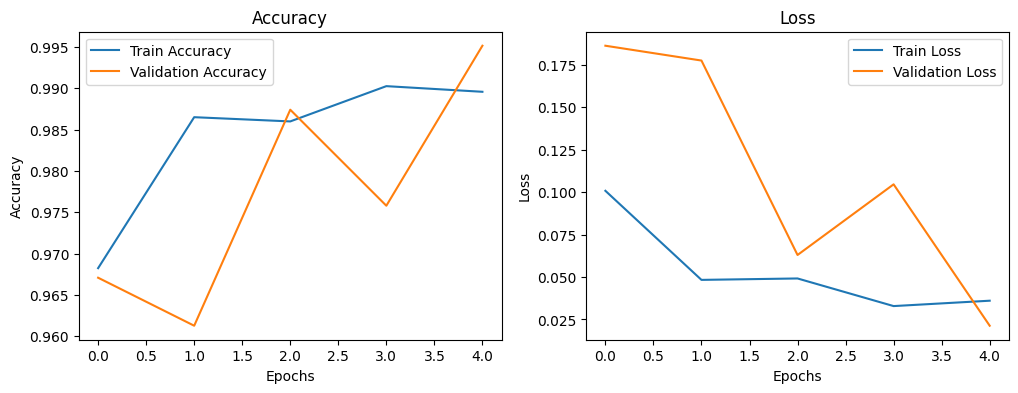

In [ ]:

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Prediction

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [ ]:

img = image.load_img('/content/data/Industrial-Equipment/Non-Defected/Non-Defected_0_1011.jpeg', target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Rescale and add batch dimension

# Predict and interpret
prediction = model.predict(img_array)
if prediction[0][0] > 0.5:
    print(f"The image is classified as: Non-Defective (Confidence: {prediction[0][0]:.2f})")
else:
    print(f"The image is classified as: Defective (Confidence: {1 - prediction[0][0]:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
The image is classified as: Non-Defective (Confidence: 1.00)


In [ ]:
img = image.load_img('/content/data/Industrial-Equipment/Defected/bearingfailures-1.png', target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Rescale and add batch dimension

# Predict and interpret
prediction = model.predict(img_array)
if prediction[0][0] > 0.5:
    print(f"The image is classified as: Non-Defective (Confidence: {prediction[0][0]:.2f})")
else:
    print(f"The image is classified as: Defective (Confidence: {1 - prediction[0][0]:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
The image is classified as: Defective (Confidence: 1.00)
